# Session 11: Convolutional Neural Networks (CNNs)

**Goal:** Work with image data using specialized neural network architectures

**Topics Covered:**
- CNN architecture (filters, pooling, flattening)
- Feature maps and convolution visualization
- Transfer Learning basics

**Hands-on:** Image classification with CNN on CIFAR-10 dataset

---

## 1. Introduction to CNNs

### Why CNNs for Images?

Regular neural networks (fully connected) have limitations with images:
- **Too many parameters**: A 200×200 RGB image = 120,000 inputs → millions of parameters in first layer
- **No spatial understanding**: Treats pixels independently, ignoring local patterns
- **Not translation invariant**: Moving an object changes everything

### CNN Advantages:

1. **Local Connectivity**: Neurons connect to small regions (receptive fields)
2. **Parameter Sharing**: Same filter applied across entire image
3. **Translation Invariance**: Detects features regardless of position
4. **Hierarchical Learning**: Low-level → Mid-level → High-level features

### CNN Building Blocks:

1. **Convolutional Layers**: Apply filters to detect features
2. **Activation Functions**: Introduce non-linearity (ReLU)
3. **Pooling Layers**: Downsample to reduce dimensions
4. **Fully Connected Layers**: Final classification
5. **Dropout**: Regularization to prevent overfitting

## 2. Setup and Imports

In [1]:
# Install required packages (uncomment if needed)
# !pip install tensorflow numpy pandas matplotlib seaborn scikit-learn pillow

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50

# Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2026-02-09 12:50:51.822217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770641452.013407      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770641452.066935      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770641452.506721      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770641452.506768      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770641452.506771      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Load and Explore CIFAR-10 Dataset

### About CIFAR-10:
- 60,000 color images (32×32 pixels)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- 50,000 training images
- 10,000 test images
- Created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton

In [3]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Dataset loaded successfully!")
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nImage dimensions: {X_train.shape[1]}×{X_train.shape[2]} pixels")
print(f"Number of color channels: {X_train.shape[3]} (RGB)")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Dataset loaded successfully!
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Image dimensions: 32×32 pixels
Number of color channels: 3 (RGB)
Pixel value range: [0, 255]


In [4]:
# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("CIFAR-10 Classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

CIFAR-10 Classes:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


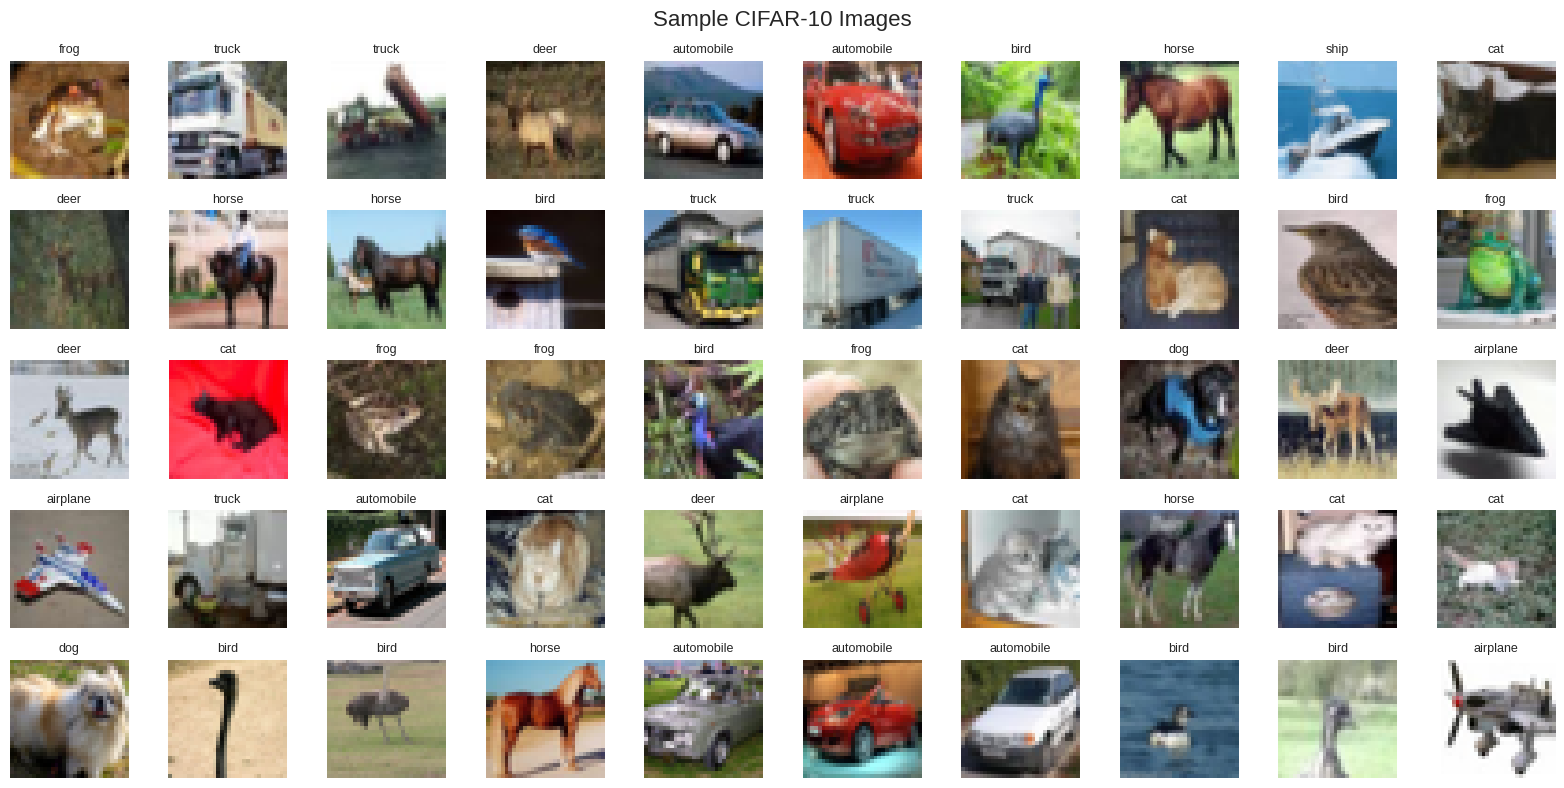

In [5]:
# Visualize sample images
fig, axes = plt.subplots(5, 10, figsize=(16, 8))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(X_train[i])
    axes[i].set_title(class_names[y_train[i][0]], fontsize=9)
    axes[i].axis('off')

plt.suptitle('Sample CIFAR-10 Images', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

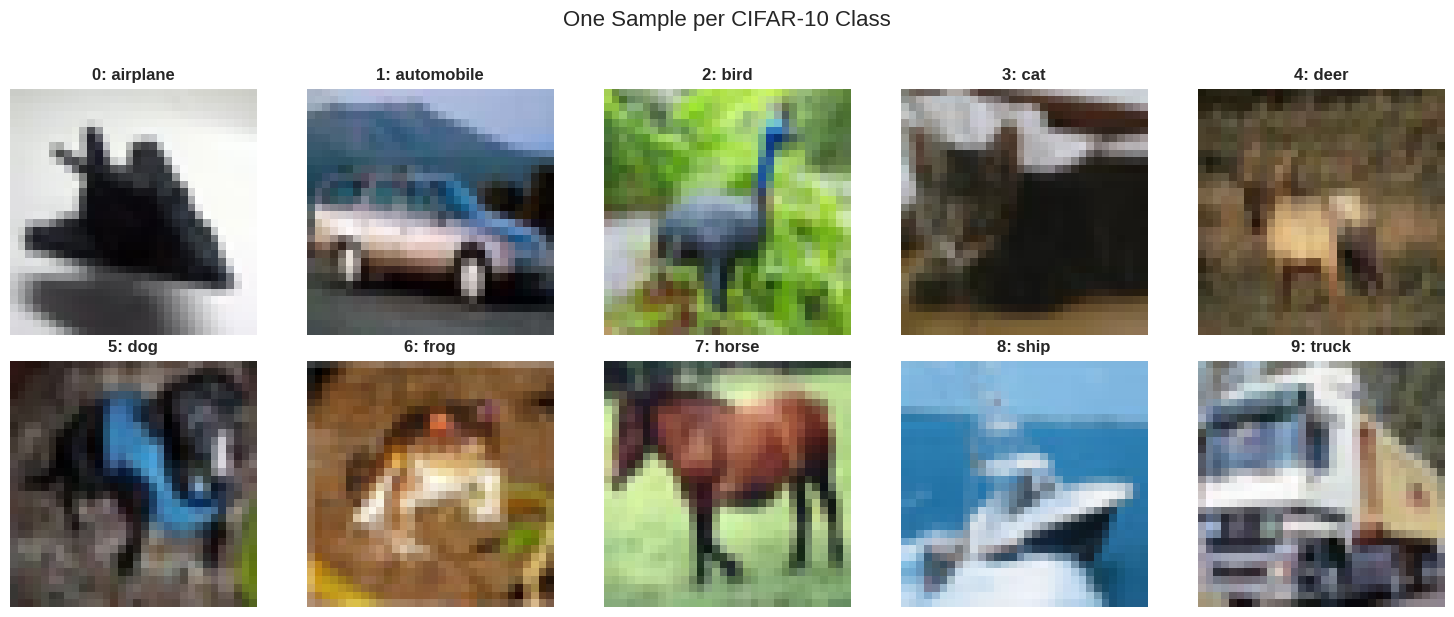

In [6]:
# Visualize one image per class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Find first occurrence of each class
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(f"{i}: {class_names[i]}", fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('One Sample per CIFAR-10 Class', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

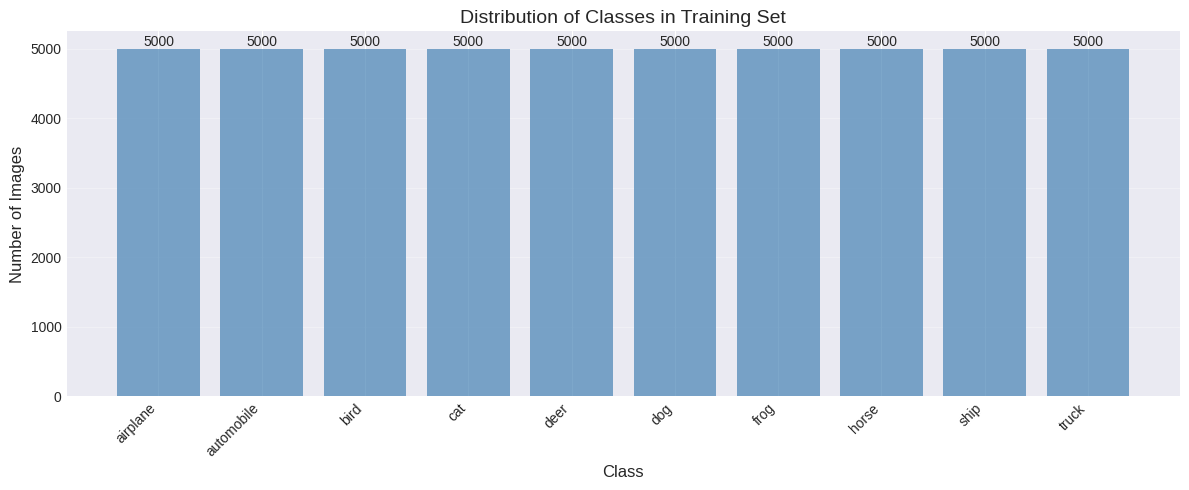

Class distribution is balanced - each class has 5,000 training samples.


In [7]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(12, 5))
bars = plt.bar([class_names[i] for i in unique], counts, color='steelblue', alpha=0.7)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Classes in Training Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Class distribution is balanced - each class has 5,000 training samples.")

## 4. Data Preprocessing

In [8]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"Original range: [{X_train.min()}, {X_train.max()}]")
print(f"Normalized range: [{X_train_normalized.min()}, {X_train_normalized.max()}]")

Original range: [0, 255]
Normalized range: [0.0, 1.0]


In [9]:
# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

print(f"Original label: {y_train[0][0]} ({class_names[y_train[0][0]]})")
print(f"One-hot encoded: {y_train_encoded[0]}")
print(f"\nEncoded shape: {y_train_encoded.shape}")

Original label: 6 (frog)
One-hot encoded: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

Encoded shape: (50000, 10)


In [10]:
# Create validation set (10% of training data)
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_normalized, y_train_encoded,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {X_train_final.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test_normalized.shape[0]} samples")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


## 5. Understanding Convolution Operations

### How Convolution Works:

1. **Filter/Kernel**: Small matrix (e.g., 3×3) that slides over the image
2. **Stride**: Step size when moving the filter
3. **Padding**: Adding border pixels to control output size
4. **Feature Map**: Output of applying filter to image

### Example Filters:
- **Edge Detection**: Highlights edges
- **Blur**: Smooths image
- **Sharpen**: Enhances details

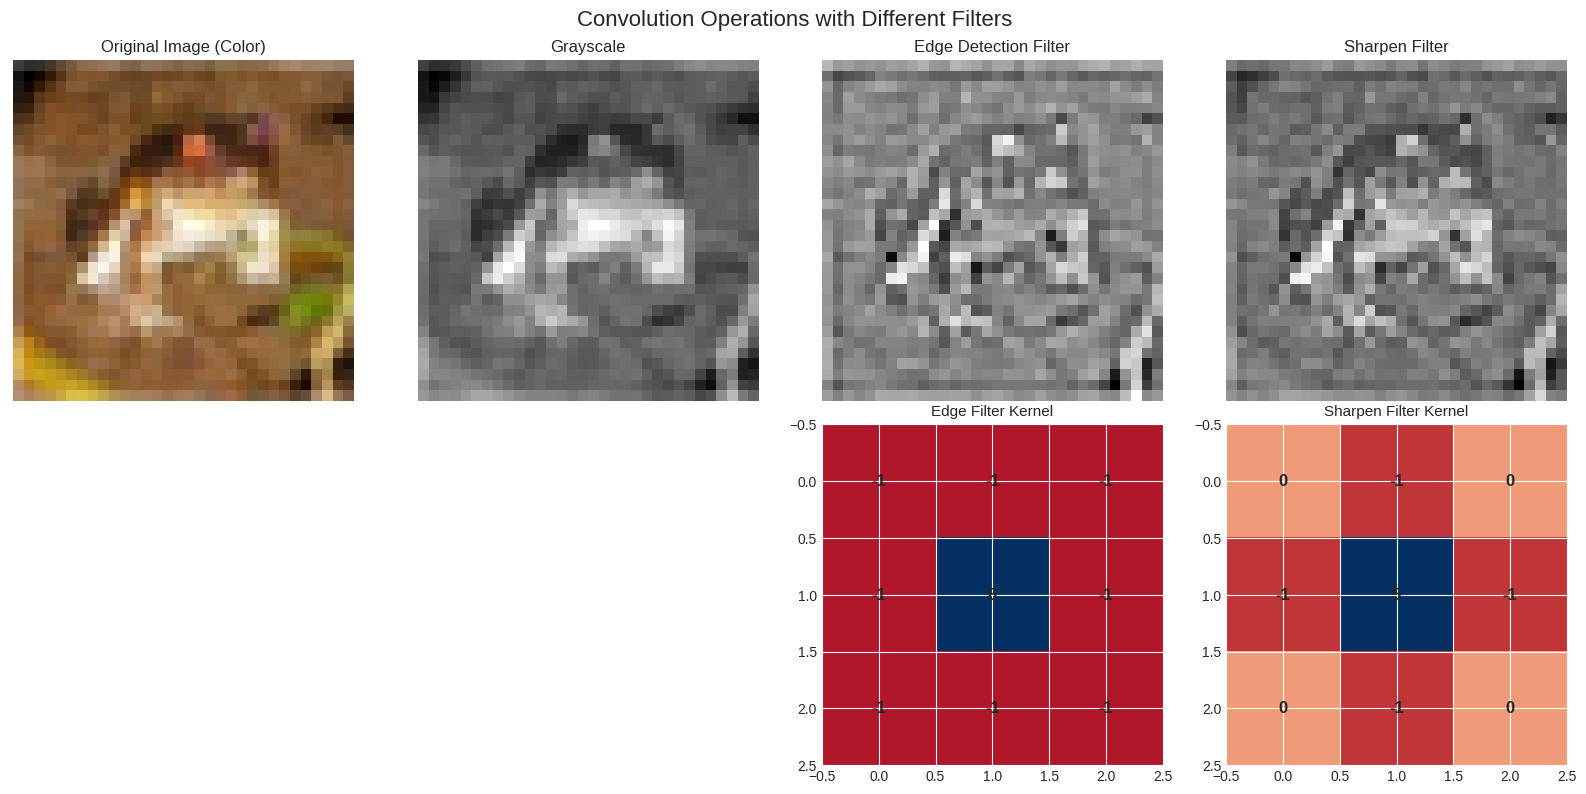

In [11]:
# Demonstrate convolution with custom filters
import scipy.ndimage as ndimage

# Select a sample image
sample_img = X_train[0]
sample_gray = np.mean(sample_img, axis=2)  # Convert to grayscale

# Define some common filters
edge_filter = np.array([[-1, -1, -1],
                        [-1,  8, -1],
                        [-1, -1, -1]])

sharpen_filter = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]])

blur_filter = np.ones((3, 3)) / 9

# Apply filters
edge_detected = ndimage.convolve(sample_gray, edge_filter)
sharpened = ndimage.convolve(sample_gray, sharpen_filter)
blurred = ndimage.convolve(sample_gray, blur_filter)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original Image (Color)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(sample_gray, cmap='gray')
axes[0, 1].set_title('Grayscale', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(edge_detected, cmap='gray')
axes[0, 2].set_title('Edge Detection Filter', fontsize=12)
axes[0, 2].axis('off')

axes[0, 3].imshow(sharpened, cmap='gray')
axes[0, 3].set_title('Sharpen Filter', fontsize=12)
axes[0, 3].axis('off')

# Display filter kernels
axes[1, 0].axis('off')

axes[1, 1].axis('off')

axes[1, 2].imshow(edge_filter, cmap='RdBu', vmin=-2, vmax=8)
axes[1, 2].set_title('Edge Filter Kernel', fontsize=11)
for i in range(3):
    for j in range(3):
        axes[1, 2].text(j, i, f'{edge_filter[i, j]:.0f}',
                       ha='center', va='center', fontsize=12, fontweight='bold')

axes[1, 3].imshow(sharpen_filter, cmap='RdBu', vmin=-2, vmax=5)
axes[1, 3].set_title('Sharpen Filter Kernel', fontsize=11)
for i in range(3):
    for j in range(3):
        axes[1, 3].text(j, i, f'{sharpen_filter[i, j]:.0f}',
                       ha='center', va='center', fontsize=12, fontweight='bold')

plt.suptitle('Convolution Operations with Different Filters', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 6. Building a Basic CNN

### Architecture:
```
Input (32×32×3)
    ↓
Conv2D (32 filters, 3×3) + ReLU
    ↓
MaxPooling (2×2)
    ↓
Conv2D (64 filters, 3×3) + ReLU
    ↓
MaxPooling (2×2)
    ↓
Conv2D (64 filters, 3×3) + ReLU
    ↓
Flatten
    ↓
Dense (64) + ReLU
    ↓
Dense (10) + Softmax
```

In [12]:
# Build basic CNN model
def create_basic_cnn():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(32, 32, 3), name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'),

        # Flatten and Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])

    return model

# Create model
basic_cnn = create_basic_cnn()

# Display architecture
basic_cnn.summary()

I0000 00:00:1770641486.807522      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

### Understanding the Architecture:

**Layer-by-layer breakdown:**

1. **Conv2D(32, 3×3)**: 32 filters of size 3×3, learns 32 different features
   - Output: 32×32×32 (height × width × filters)
   
2. **MaxPooling2D(2×2)**: Takes maximum value in 2×2 windows, reduces size by half
   - Output: 16×16×32
   
3. **Conv2D(64, 3×3)**: 64 filters, more complex features
   - Output: 16×16×64
   
4. **MaxPooling2D(2×2)**: Reduces dimensions again
   - Output: 8×8×64
   
5. **Conv2D(64, 3×3)**: Even deeper features
   - Output: 8×8×64
   
6. **Flatten**: Converts 3D to 1D (8×8×64 = 4,096)

7. **Dense(64)**: Fully connected layer for classification

8. **Dense(10)**: Output layer with 10 classes

In [13]:
# Compile the model
basic_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [14]:
# Train the basic CNN
print("Training Basic CNN...")
print("="*60)

history_basic = basic_cnn.fit(
    X_train_final, y_train_final,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nTraining completed!")

Training Basic CNN...
Epoch 1/15


I0000 00:00:1770641490.979494      68 service.cc:152] XLA service 0x7a64f8004260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770641490.979544      68 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770641491.383220      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


 35/352 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1742 - loss: 2.2288

I0000 00:00:1770641493.561343      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3455 - loss: 1.8011 - val_accuracy: 0.5458 - val_loss: 1.2655
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5546 - loss: 1.2488 - val_accuracy: 0.6274 - val_loss: 1.0659
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6265 - loss: 1.0508 - val_accuracy: 0.6654 - val_loss: 0.9579
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6746 - loss: 0.9264 - val_accuracy: 0.6860 - val_loss: 0.9009
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7069 - loss: 0.8396 - val_accuracy: 0.6938 - val_loss: 0.8663
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7329 - loss: 0.7698 - val_accuracy: 0.6982 - val_loss: 0.8438
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7558 - loss: 0.7066 - val_accuracy: 0.7066 - val_loss: 0.8278
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7747 - loss: 0.6533 - val_accuracy: 0.7098 - val

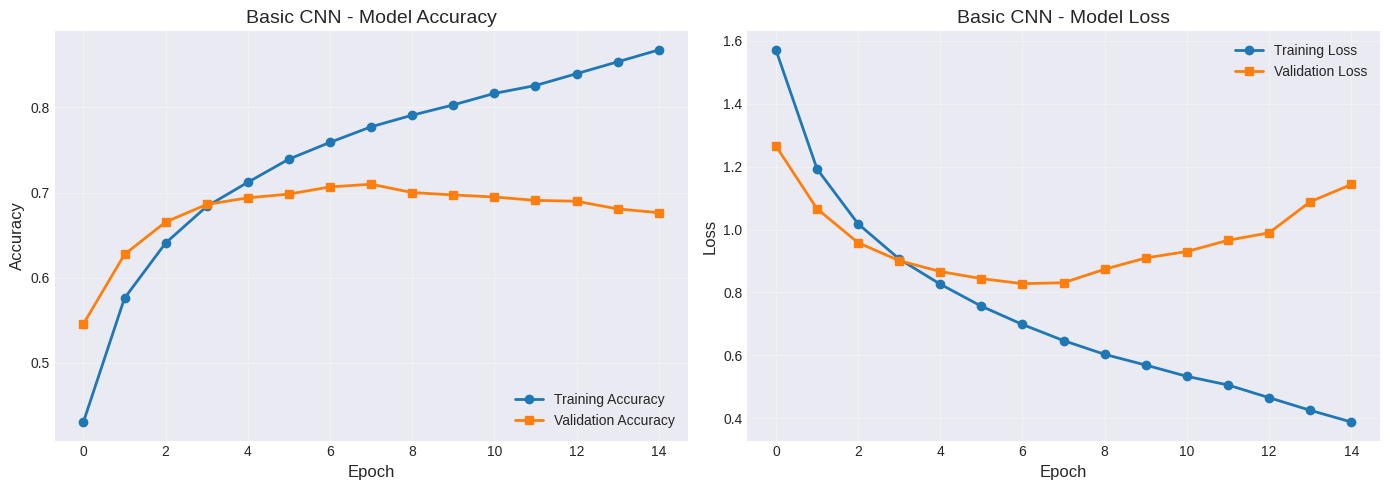

In [15]:
# Plot training history
def plot_training_history(history, title_prefix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[0].set_title(f'{title_prefix}Model Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[1].set_title(f'{title_prefix}Model Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_basic, 'Basic CNN - ')

In [16]:
# Evaluate on test set
test_loss, test_accuracy = basic_cnn.evaluate(X_test_normalized, y_test_encoded, verbose=0)

print("="*60)
print("BASIC CNN - TEST SET PERFORMANCE")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*60)

BASIC CNN - TEST SET PERFORMANCE
Test Accuracy: 0.6797 (67.97%)
Test Loss: 1.1834


## 7. Visualizing Feature Maps

Let's visualize what the CNN "sees" at different layers - the feature maps (activation outputs).

In [17]:
# Create a model that outputs feature maps from convolutional layers

# Define an input tensor for the new activation model
input_tensor = tf.keras.Input(shape=(32, 32, 3))

# We need to reconstruct the path of the input tensor through the basic_cnn
# to correctly capture the intermediate outputs in the context of `input_tensor`.
x = input_tensor
layer_outputs_for_activation_model = []

# Iterate through the layers of the 'basic_cnn' model
for layer in basic_cnn.layers:
    # Apply the current layer to the tensor 'x'
    x = layer(x)
    # If it's a convolutional layer, store its output
    if 'conv' in layer.name:
        layer_outputs_for_activation_model.append(x)

# Create the activation model using the functional API,
# ensuring the outputs are correctly linked to the input_tensor's graph.
activation_model = models.Model(inputs=input_tensor, outputs=layer_outputs_for_activation_model)

# Select a sample image
sample_idx = 15
sample_image = X_test_normalized[sample_idx:sample_idx+1]
sample_label = class_names[y_test[sample_idx][0]]

# Get activations
activations = activation_model.predict(sample_image)

print(f"Sample image: {sample_label}")
print(f"Number of convolutional layers: {len(activations)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Sample image: ship
Number of convolutional layers: 3


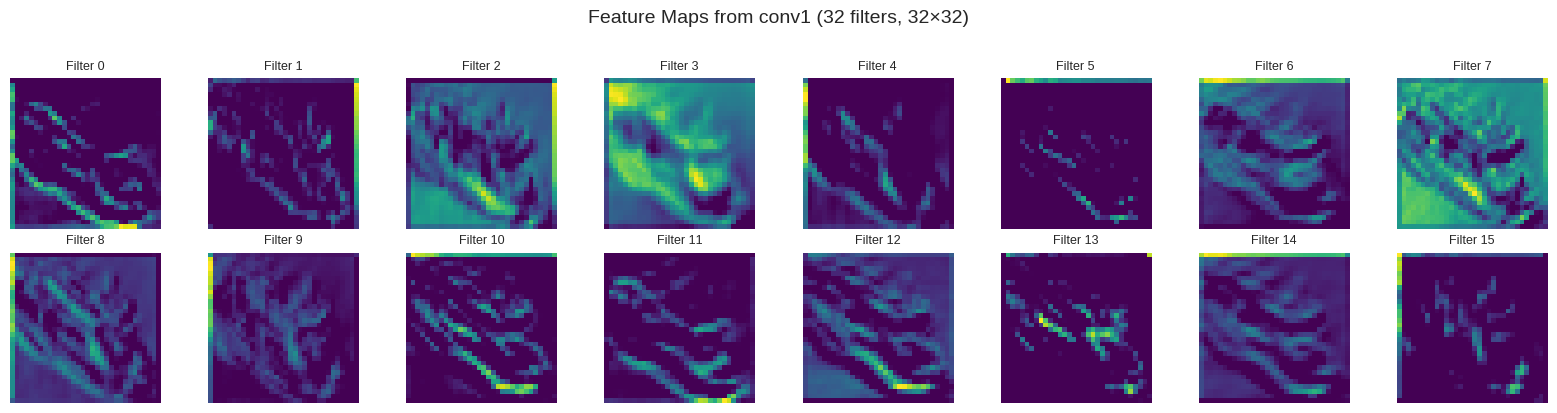

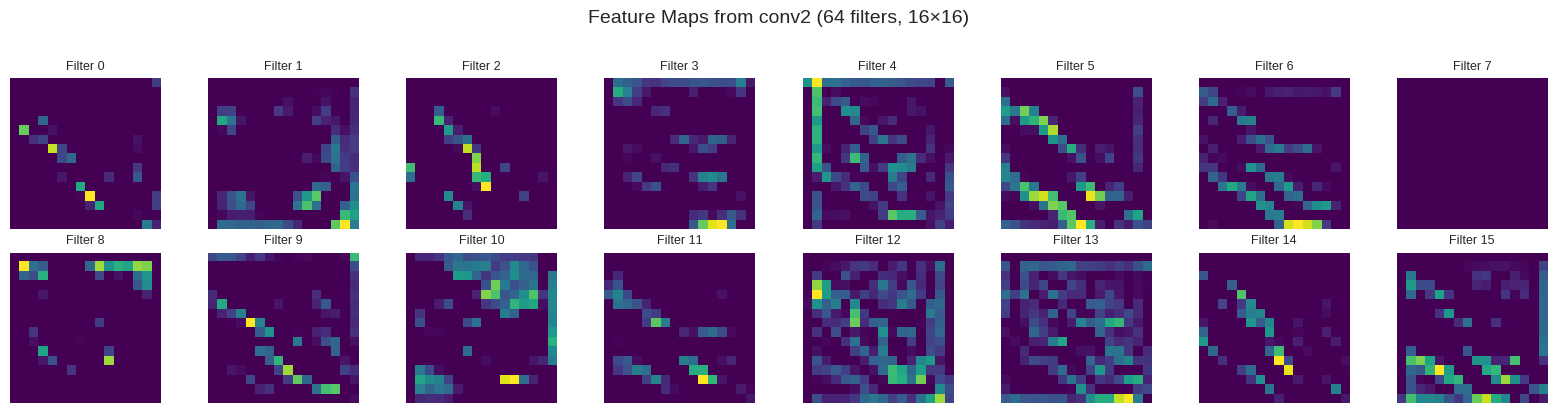

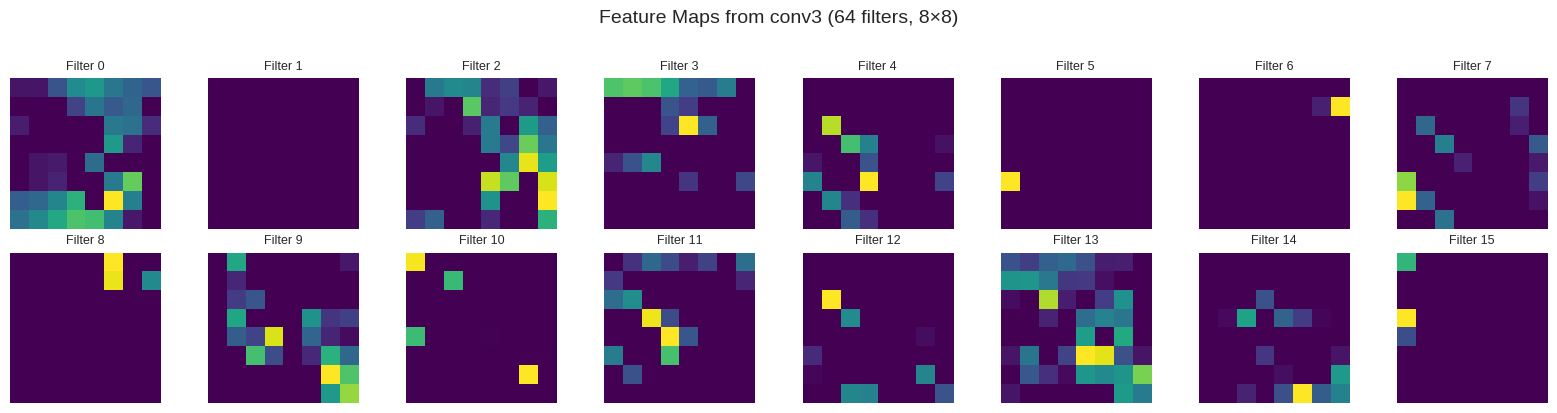

In [18]:
# Visualize feature maps from first convolutional layer
layer_names = ['conv1', 'conv2', 'conv3']

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of filters
    size = layer_activation.shape[1]  # Feature map size

    # Display up to 16 feature maps
    n_cols = 8
    n_rows = min(2, n_features // n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4))

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for row in range(n_rows):
        for col in range(n_cols):
            channel_idx = row * n_cols + col
            if channel_idx < n_features:
                channel_image = layer_activation[0, :, :, channel_idx]
                axes[row, col].imshow(channel_image, cmap='viridis')
                axes[row, col].set_title(f'Filter {channel_idx}', fontsize=9)
            axes[row, col].axis('off')

    plt.suptitle(f'Feature Maps from {layer_name} ({n_features} filters, {size}×{size})',
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

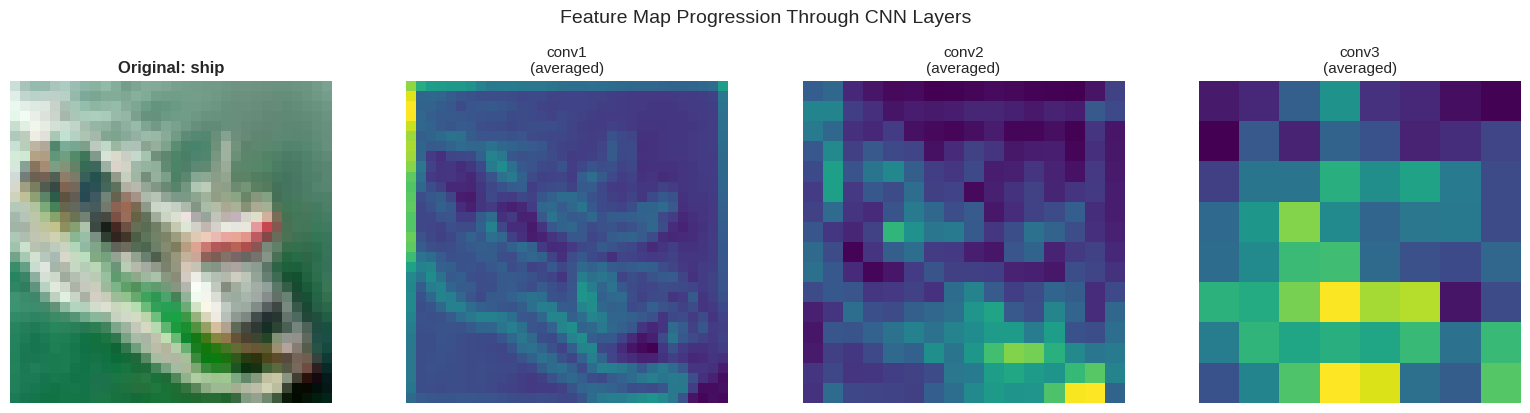


Observation:
- Early layers (conv1): Detect simple features like edges and colors
- Middle layers (conv2): Detect textures and patterns
- Deeper layers (conv3): Detect complex, abstract features


In [19]:
# Display the original image alongside feature maps
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(X_test[sample_idx])
axes[0].set_title(f'Original: {sample_label}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Average activation from each conv layer
for i, (layer_name, activation) in enumerate(zip(layer_names, activations)):
    # Average across all filters
    avg_activation = np.mean(activation[0], axis=-1)
    axes[i+1].imshow(avg_activation, cmap='viridis')
    axes[i+1].set_title(f'{layer_name}\n(averaged)', fontsize=11)
    axes[i+1].axis('off')

plt.suptitle('Feature Map Progression Through CNN Layers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Early layers (conv1): Detect simple features like edges and colors")
print("- Middle layers (conv2): Detect textures and patterns")
print("- Deeper layers (conv3): Detect complex, abstract features")

## 8. Improved CNN with Regularization

Let's build a more sophisticated CNN with:
- More convolutional layers
- Batch normalization (helps training)
- Dropout (prevents overfitting)
- Data augmentation

In [20]:
# Build improved CNN
def create_improved_cnn():
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

improved_cnn = create_improved_cnn()
improved_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [21]:
# Compile with learning rate schedule
from tensorflow.keras.optimizers import Adam

improved_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Improved model compiled!")

Improved model compiled!


In [22]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images
    width_shift_range=0.1,       # Randomly shift horizontally
    height_shift_range=0.1,      # Randomly shift vertically
    horizontal_flip=True,        # Randomly flip images
    zoom_range=0.1               # Randomly zoom
)

# Fit the augmentation on training data
datagen.fit(X_train_final)

print("Data augmentation configured!")

Data augmentation configured!


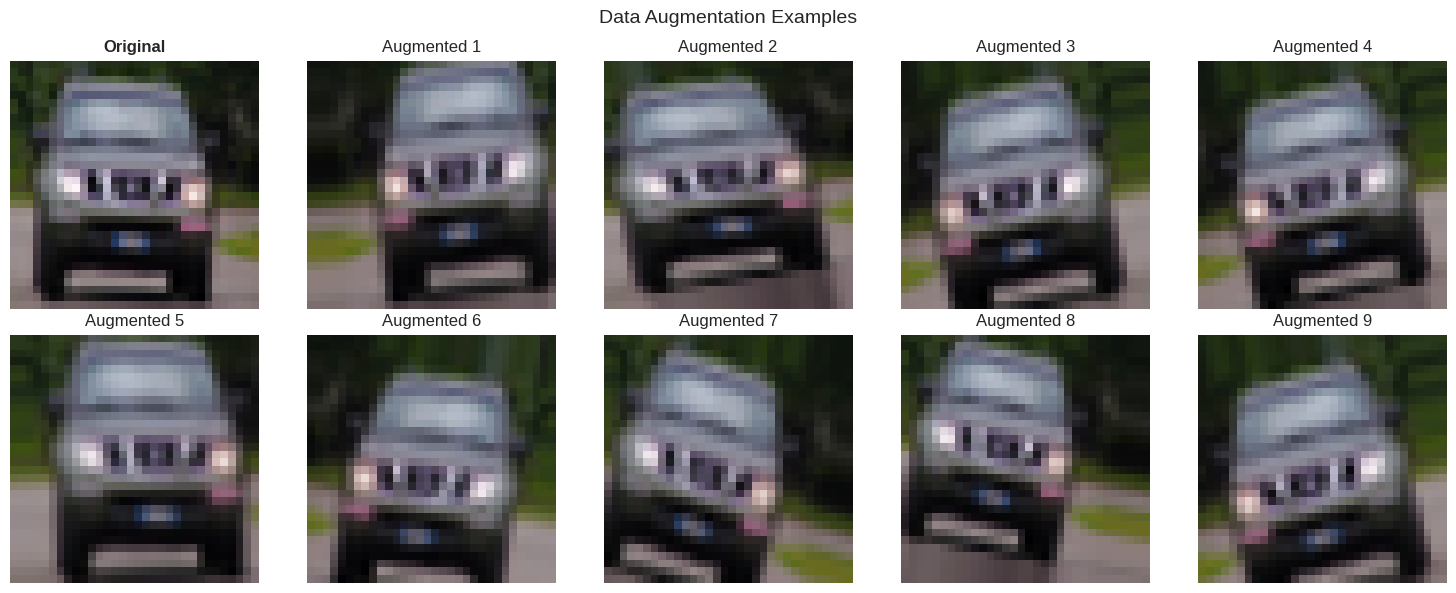

In [23]:
# Visualize augmented images
sample_img = X_train_final[0:1]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Original
axes[0].imshow(sample_img[0])
axes[0].set_title('Original', fontweight='bold')
axes[0].axis('off')

# Augmented versions
i = 1
for batch in datagen.flow(sample_img, batch_size=1):
    axes[i].imshow(batch[0])
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')
    i += 1
    if i >= 10:
        break

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early Stopping: Stops training if validation loss doesn't improve")
print("- Learning Rate Reduction: Reduces learning rate when stuck")

Callbacks configured:
- Early Stopping: Stops training if validation loss doesn't improve
- Learning Rate Reduction: Reduces learning rate when stuck


In [25]:
# Train improved CNN with data augmentation
print("Training Improved CNN with Data Augmentation...")
print("="*60)

history_improved = improved_cnn.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=128),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Training Improved CNN with Data Augmentation...
Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.3075 - loss: 2.1921 - val_accuracy: 0.1892 - val_loss: 3.1096 - learning_rate: 0.0010
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.4980 - loss: 1.3939 - val_accuracy: 0.6184 - val_loss: 1.0677 - learning_rate: 0.0010
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5830 - loss: 1.1695 - val_accuracy: 0.6314 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6256 - loss: 1.0605 - val_accuracy: 0.6820 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6601 - loss: 0.9588 - val_accuracy: 0.7064 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.6944 - loss: 0.8730 - val_accuracy: 0.7172 - val_loss: 0.8048 - learning_rate: 0.0010
Epoch 7/30
352/352 ━━━━━━━━━

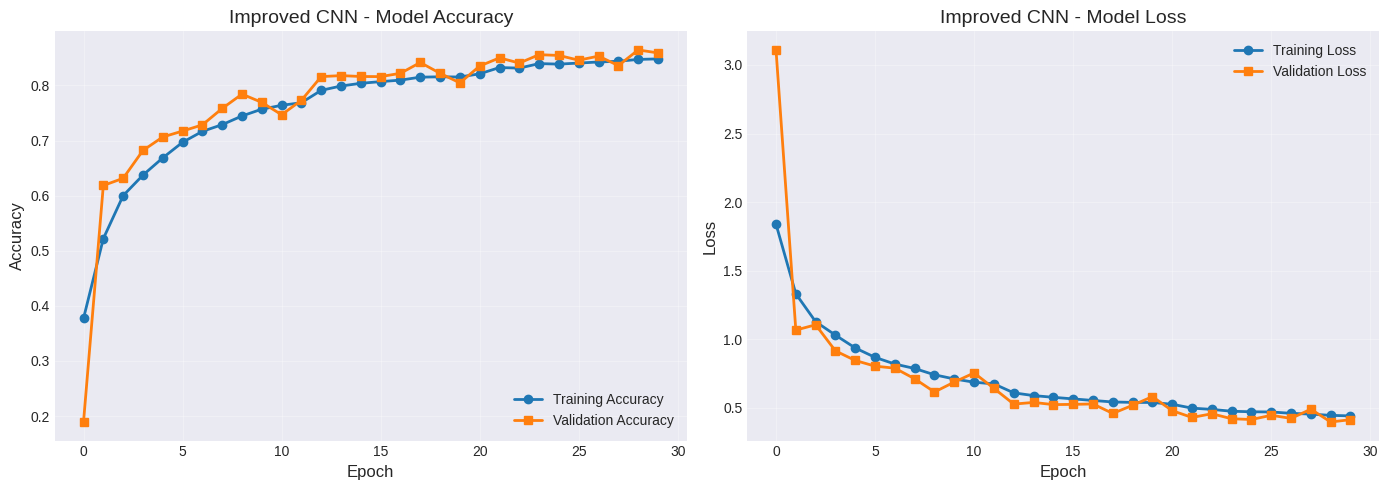

In [26]:
# Plot improved model history
plot_training_history(history_improved, 'Improved CNN - ')

In [27]:
# Evaluate improved model
improved_test_loss, improved_test_accuracy = improved_cnn.evaluate(
    X_test_normalized, y_test_encoded, verbose=0
)

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"Basic CNN Test Accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Improved CNN Test Accuracy: {improved_test_accuracy:.4f} ({improved_test_accuracy*100:.2f}%)")
print(f"\nImprovement: {(improved_test_accuracy - test_accuracy)*100:.2f}%")
print("="*60)

MODEL COMPARISON
Basic CNN Test Accuracy:    0.6797 (67.97%)
Improved CNN Test Accuracy: 0.8554 (85.54%)

Improvement: 17.57%


## 9. Transfer Learning

### What is Transfer Learning?

Transfer learning uses pre-trained models (trained on large datasets like ImageNet) as a starting point:

**Benefits:**
- Faster training
- Better performance with less data
- Learns from millions of images

**Popular Pre-trained Models:**
- VGG16/VGG19
- ResNet50/ResNet101
- InceptionV3
- MobileNet
- EfficientNet

### Two Approaches:
1. **Feature Extraction**: Use pre-trained layers as fixed feature extractors
2. **Fine-tuning**: Unfreeze some layers and retrain them

In [28]:
# Load pre-trained VGG16 (without top classification layers)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze the base model layers
base_model.trainable = False

print("VGG16 base model loaded!")
print(f"Number of layers: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
VGG16 base model loaded!
Number of layers: 19
Trainable: False


In [29]:
# Build transfer learning model
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
# Train transfer learning model
print("Training Transfer Learning Model...")
print("="*60)

history_transfer = transfer_model.fit(
    X_train_final, y_train_final,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nTraining completed!")

Training Transfer Learning Model...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3625 - loss: 1.7912 - val_accuracy: 0.5492 - val_loss: 1.3062
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5297 - loss: 1.3572 - val_accuracy: 0.5684 - val_loss: 1.2282
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5560 - loss: 1.2746 - val_accuracy: 0.5816 - val_loss: 1.1970
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5677 - loss: 1.2345 - val_accuracy: 0.5926 - val_loss: 1.1704
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5787 - loss: 1.2009 - val_accuracy: 0.5916 - val_loss: 1.1563
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5872 - loss: 1.1767 - val_accuracy: 0.5972 - val_loss: 1.1459
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5969 - loss: 1.1574 - val_accuracy: 0.6038 - val_loss: 1.1315
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accur

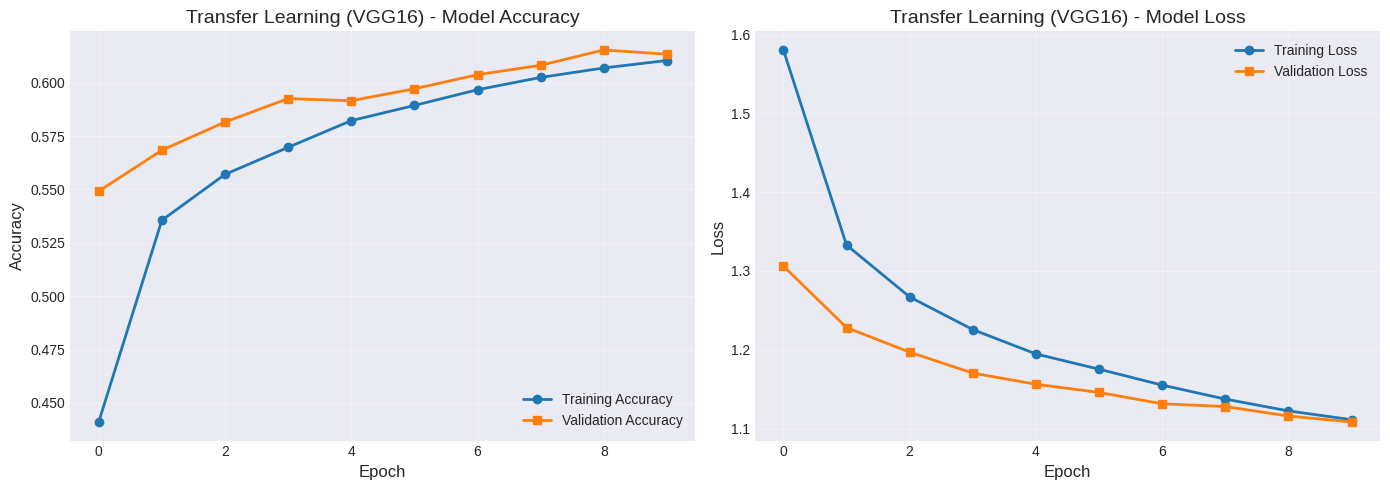

In [31]:
# Plot transfer learning history
plot_training_history(history_transfer, 'Transfer Learning (VGG16) - ')

In [32]:
# Evaluate transfer learning model
transfer_test_loss, transfer_test_accuracy = transfer_model.evaluate(
    X_test_normalized, y_test_encoded, verbose=0
)

print("="*60)
print("COMPLETE MODEL COMPARISON")
print("="*60)
print(f"Basic CNN:              {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Improved CNN:           {improved_test_accuracy:.4f} ({improved_test_accuracy*100:.2f}%)")
print(f"Transfer Learning:      {transfer_test_accuracy:.4f} ({transfer_test_accuracy*100:.2f}%)")
print("="*60)

COMPLETE MODEL COMPARISON
Basic CNN:              0.6797 (67.97%)
Improved CNN:           0.8554 (85.54%)
Transfer Learning:      0.6015 (60.15%)


## 10. Model Predictions and Analysis

In [33]:
# Make predictions with the best model (improved_cnn)
predictions = improved_cnn.predict(X_test_normalized)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test.flatten()

print(f"Predictions generated for {len(predictions)} test samples")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Predictions generated for 10000 test samples


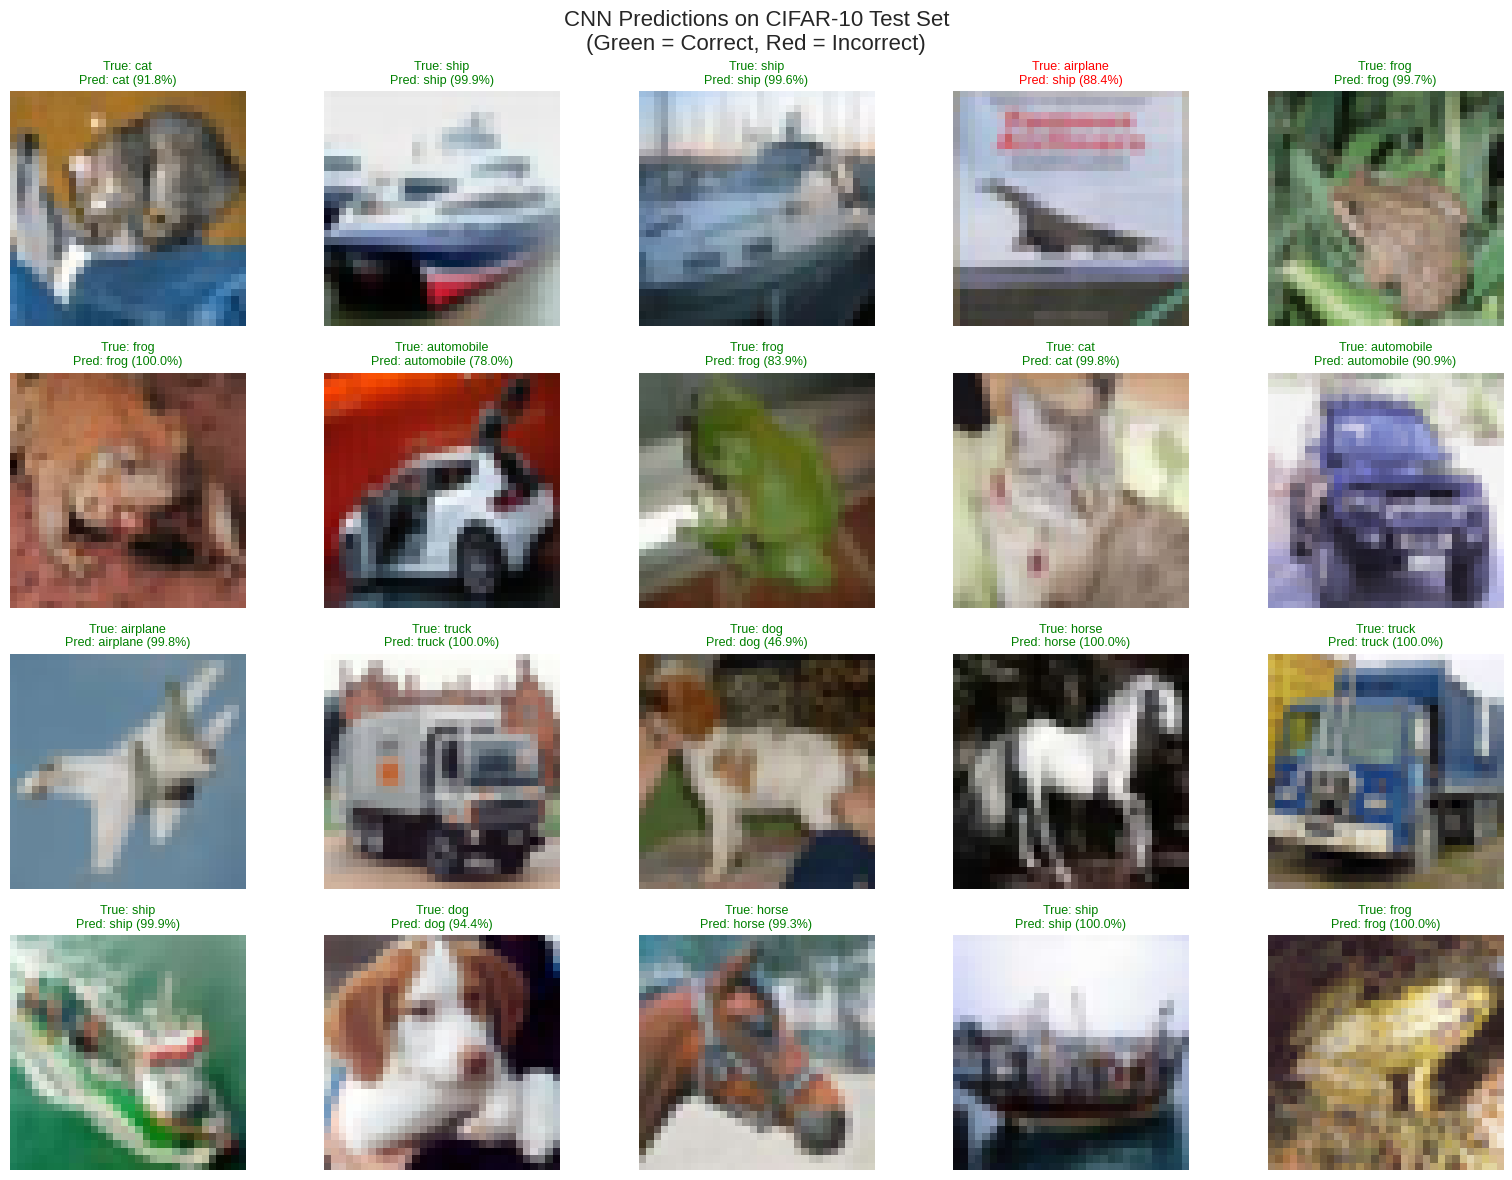

In [34]:
# Visualize predictions
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.ravel()

for i in range(20):
    axes[i].imshow(X_test[i])
    pred_label = predicted_classes[i]
    true_label = true_classes[i]
    confidence = predictions[i][pred_label] * 100

    color = 'green' if pred_label == true_label else 'red'

    axes[i].set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)",
        color=color, fontsize=9
    )
    axes[i].axis('off')

plt.suptitle('CNN Predictions on CIFAR-10 Test Set\n(Green = Correct, Red = Incorrect)',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

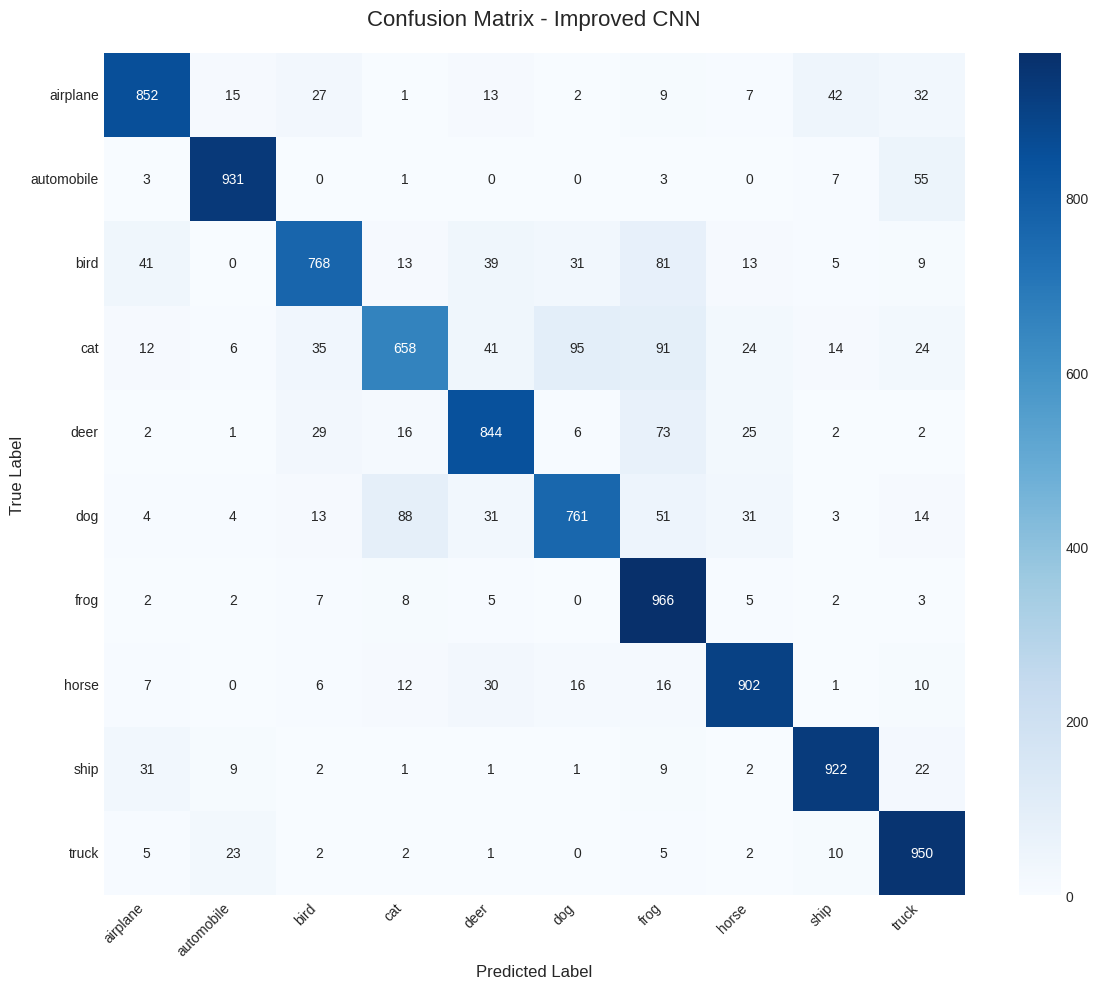

In [35]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Improved CNN', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
# Classification report
print("\nDetailed Classification Report:")
print("="*70)
print(classification_report(true_classes, predicted_classes,
                          target_names=class_names))


Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.85      0.87      1000
  automobile       0.94      0.93      0.94      1000
        bird       0.86      0.77      0.81      1000
         cat       0.82      0.66      0.73      1000
        deer       0.84      0.84      0.84      1000
         dog       0.83      0.76      0.80      1000
        frog       0.74      0.97      0.84      1000
       horse       0.89      0.90      0.90      1000
        ship       0.91      0.92      0.92      1000
       truck       0.85      0.95      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



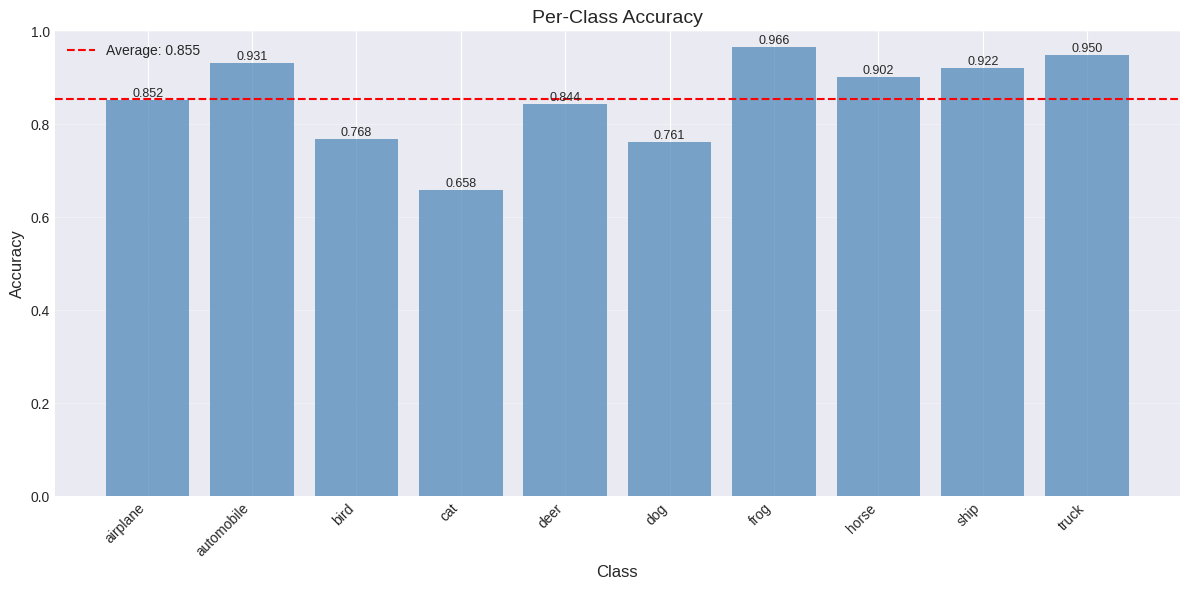


Best performing classes:
  frog: 0.966
  truck: 0.950
  automobile: 0.931

Worst performing classes:
  cat: 0.658
  dog: 0.761
  bird: 0.768


In [37]:
# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracies, color='steelblue', alpha=0.7)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.axhline(y=class_accuracies.mean(), color='red', linestyle='--',
           label=f'Average: {class_accuracies.mean():.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nBest performing classes:")
for i in np.argsort(class_accuracies)[-3:][::-1]:
    print(f"  {class_names[i]}: {class_accuracies[i]:.3f}")

print("\nWorst performing classes:")
for i in np.argsort(class_accuracies)[:3]:
    print(f"  {class_names[i]}: {class_accuracies[i]:.3f}")

## 11. Analyzing Misclassifications

In [38]:
# Find misclassified examples
misclassified_idx = np.where(predicted_classes != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_idx)}")
print(f"Accuracy: {(1 - len(misclassified_idx)/len(true_classes))*100:.2f}%")

Total misclassifications: 1446
Accuracy: 85.54%


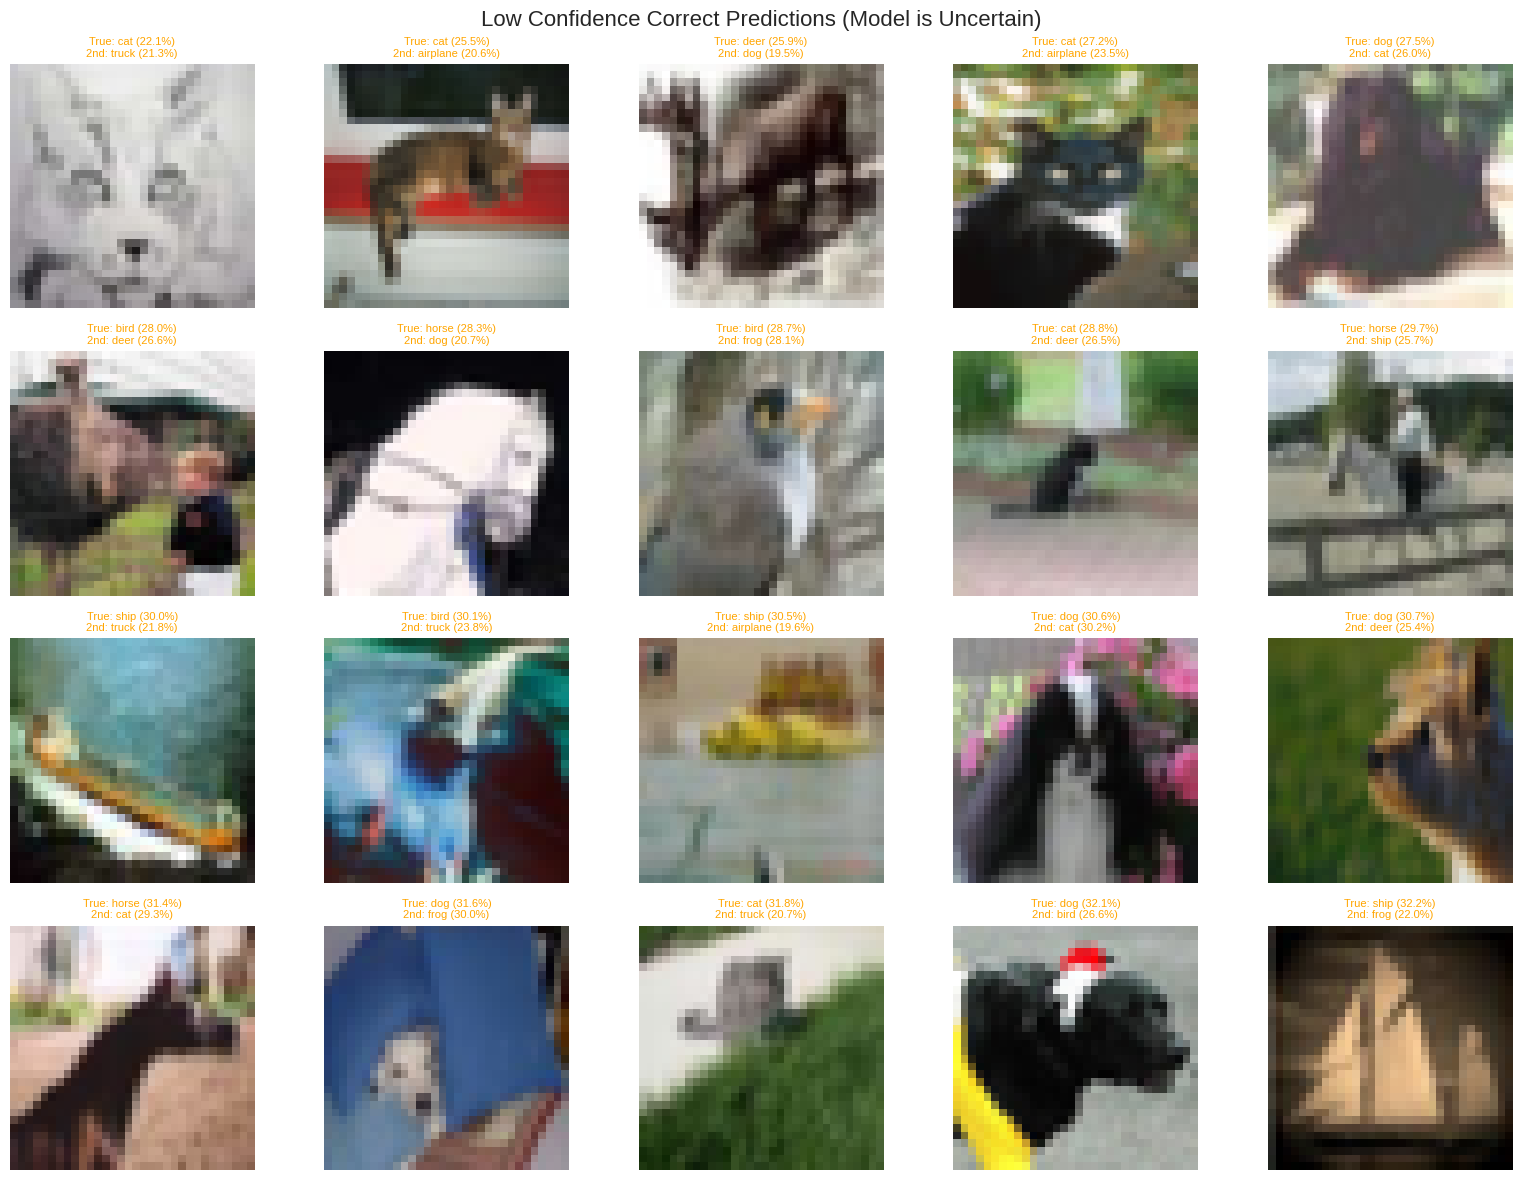

In [39]:
# Visualize worst predictions (lowest confidence correct predictions)
correct_idx = np.where(predicted_classes == true_classes)[0]
correct_confidences = [predictions[i][true_classes[i]] for i in correct_idx]
lowest_confidence_idx = correct_idx[np.argsort(correct_confidences)[:20]]

fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.ravel()

for i, idx in enumerate(lowest_confidence_idx):
    axes[i].imshow(X_test[idx])
    true_label = true_classes[idx]
    confidence = predictions[idx][true_label] * 100

    # Get top 2 predictions
    top2_idx = np.argsort(predictions[idx])[-2:][::-1]

    axes[i].set_title(
        f"True: {class_names[true_label]} ({confidence:.1f}%)\n" +
        f"2nd: {class_names[top2_idx[1]]} ({predictions[idx][top2_idx[1]]*100:.1f}%)",
        color='orange', fontsize=8
    )
    axes[i].axis('off')

plt.suptitle('Low Confidence Correct Predictions (Model is Uncertain)',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

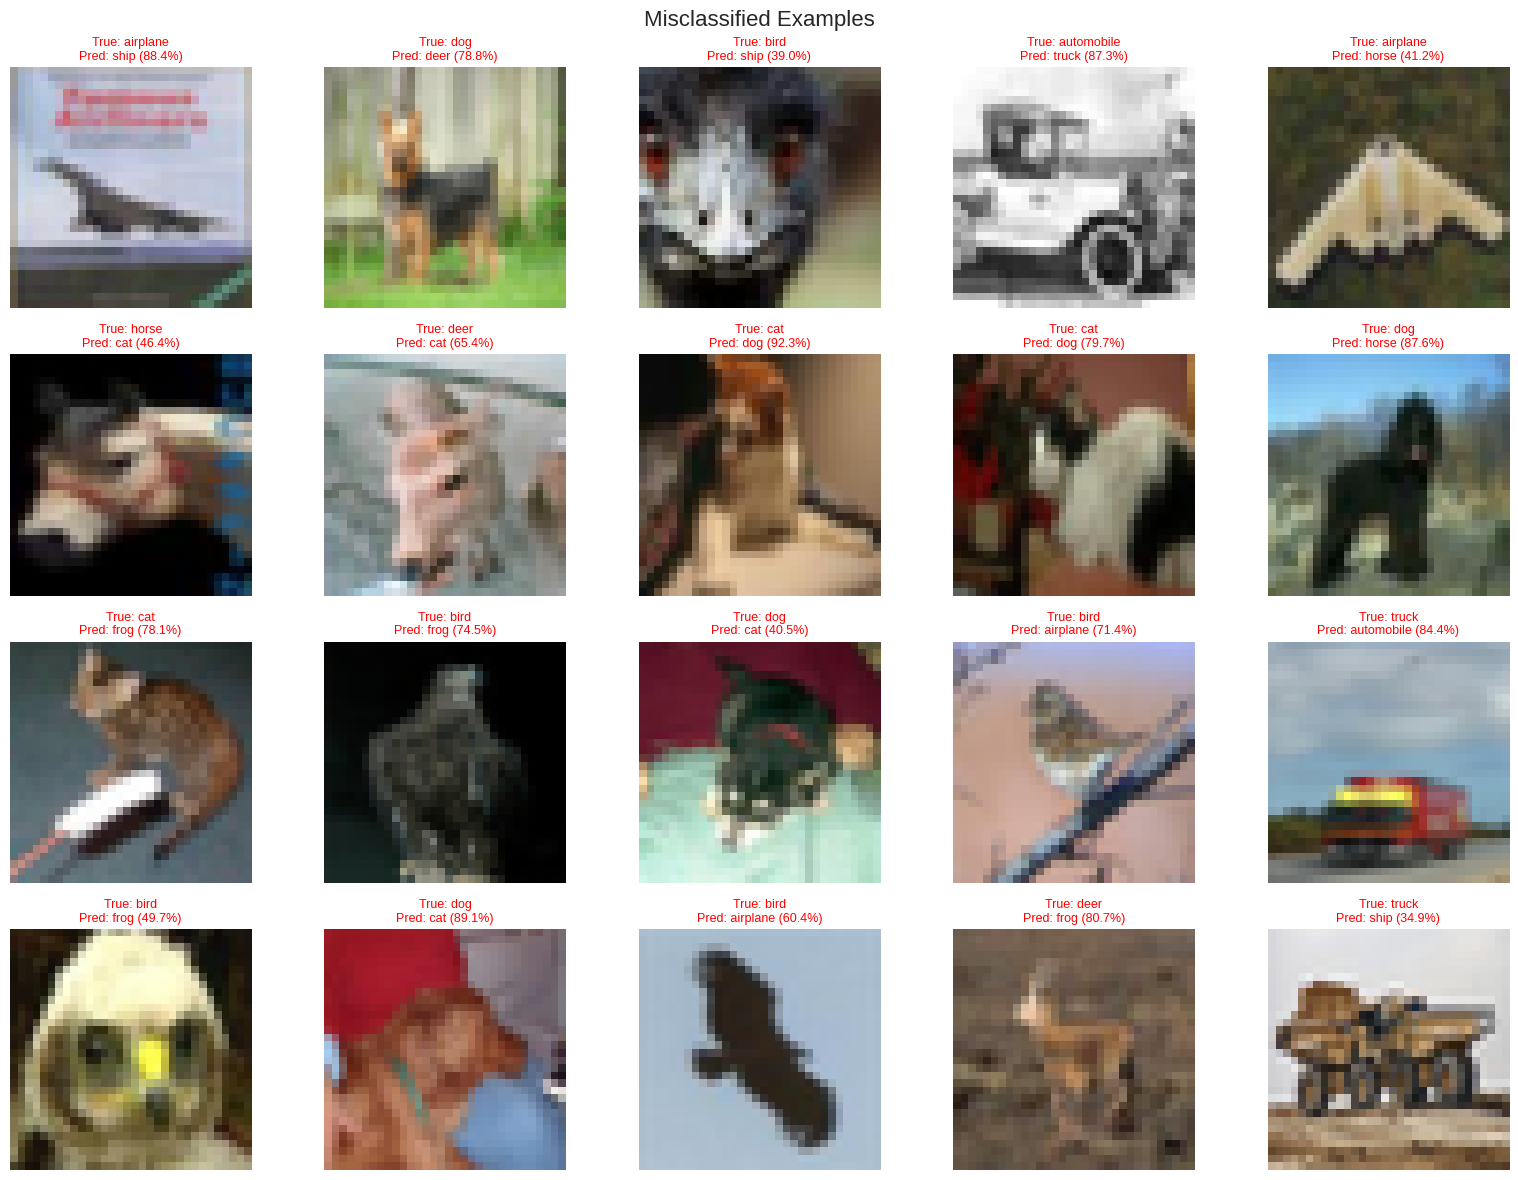

In [40]:
# Visualize misclassifications
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.ravel()

for i in range(min(20, len(misclassified_idx))):
    idx = misclassified_idx[i]
    axes[i].imshow(X_test[idx])
    pred_label = predicted_classes[idx]
    true_label = true_classes[idx]
    confidence = predictions[idx][pred_label] * 100

    axes[i].set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)",
        color='red', fontsize=9
    )
    axes[i].axis('off')

plt.suptitle('Misclassified Examples', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 12. Save Models

In [41]:
# Save the best models
basic_cnn.save('cifar10_basic_cnn.h5')
improved_cnn.save('cifar10_improved_cnn.h5')
transfer_model.save('cifar10_transfer_learning.h5')

print("Models saved successfully!")
print("- cifar10_basic_cnn.h5")
print("- cifar10_improved_cnn.h5")
print("- cifar10_transfer_learning.h5")

Models saved successfully!
- cifar10_basic_cnn.h5
- cifar10_improved_cnn.h5
- cifar10_transfer_learning.h5


## 13. Key Takeaways

### What We Learned:

1. **CNN Architecture:**
   - **Convolutional layers** detect features using filters
   - **Pooling layers** reduce spatial dimensions
   - **Dense layers** perform final classification

2. **Key Components:**
   - **Filters/Kernels**: Detect patterns (edges, textures, objects)
   - **Feature Maps**: Output of convolutional operations
   - **Padding**: Controls output size ('same' or 'valid')
   - **Stride**: Step size for filter movement

3. **Regularization Techniques:**
   - **Dropout**: Randomly deactivates neurons during training
   - **Batch Normalization**: Normalizes layer inputs
   - **Data Augmentation**: Creates variations of training images

4. **Transfer Learning:**
   - Uses pre-trained models (VGG16, ResNet, etc.)
   - Faster training with better results
   - Especially useful with limited data

5. **Best Practices:**
   - Start with simple architecture, then add complexity
   - Use data augmentation to increase dataset size
   - Monitor training curves for overfitting
   - Use callbacks (early stopping, learning rate reduction)
   - Visualize feature maps to understand what CNN learns

### CNN vs Regular Neural Networks:

| Aspect | Regular NN | CNN |
|--------|-----------|-----|
| **Input** | Flattened vector | Spatial structure preserved |
| **Parameters** | Many (fully connected) | Fewer (parameter sharing) |
| **Features** | Manual feature engineering | Automatic feature learning |
| **Translation** | Not invariant | Translation invariant |
| **Use Case** | Tabular data | Images, videos, spatial data |

### Architecture Patterns:

```
Common CNN Pattern:
[Conv → ReLU → Conv → ReLU → Pool → Dropout] × N
→ Flatten
→ Dense → Dropout
→ Output
```

### Performance Tips:

1. **Increase depth gradually**: More layers = more abstract features
2. **Double filters after pooling**: Compensates for reduced spatial size
3. **Use small filters (3×3)**: More efficient than large filters
4. **Batch size matters**: Larger = faster but may hurt generalization
5. **Learning rate scheduling**: Reduce LR when stuck

### Next Steps:

- **Advanced Architectures**: ResNet, DenseNet, EfficientNet
- **Object Detection**: YOLO, R-CNN, SSD
- **Semantic Segmentation**: U-Net, Mask R-CNN
- **Image Generation**: GANs, VAEs, Diffusion Models
- **Video Analysis**: 3D CNNs, RNNs with CNNs
- **Multi-modal Learning**: Combining images with text

## 14. Exercises

### Beginner:
1. **Modify Architecture**: Try different numbers of filters (16, 32, 64, 128)
2. **Change Activation**: Replace ReLU with LeakyReLU or ELU
3. **Adjust Dropout**: Test different dropout rates (0.1, 0.3, 0.5)
4. **Pooling Variations**: Try AveragePooling instead of MaxPooling

### Intermediate:
5. **Implement ResNet-style Skip Connections**: Add residual connections
6. **Try Different Optimizers**: Compare SGD, Adam, RMSprop, AdaGrad
7. **Learning Rate Experiments**: Test different learning rates (0.1, 0.01, 0.001)
8. **Custom Data Augmentation**: Add more sophisticated augmentations

### Advanced:
9. **Fine-tune Transfer Learning**: Unfreeze last few layers of VGG16
10. **Grad-CAM Visualization**: Visualize which parts of image influenced prediction
11. **Ensemble Methods**: Combine predictions from multiple models
12. **Custom Dataset**: Train on your own image dataset

## Conclusion

Congratulations! You've successfully:
- Built CNNs from scratch for image classification
- Understood CNN architecture (Conv, Pool, Dense layers)
- Visualized feature maps and learned features
- Applied regularization techniques (Dropout, BatchNorm)
- Implemented data augmentation
- Used transfer learning with pre-trained models
- Achieved strong performance on CIFAR-10

CNNs are the foundation of modern computer vision. Keep experimenting!

---

**Resources:**
- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)
- [Deep Learning Book - Chapter 9: CNNs](https://www.deeplearningbook.org/contents/convnets.html)
- [TensorFlow CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn)
- [Keras Applications Documentation](https://keras.io/api/applications/)
- [Papers with Code - Computer Vision](https://paperswithcode.com/area/computer-vision)